# Dimensionality Reduction

In [1]:
%matplotlib inline
import os
import numpy as np
from matplotlib import pyplot as plt
import mpld3

In [2]:
import neuralyzer

In [3]:
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (8,8)

In [4]:
#datafile = '/Users/michael/coding/RIKEN/data/140316/data5/data2/Image_0001_0001_channel0_13000_14000.tif'
#datafile = '/home/michael/datac/140316/data5/data2/Image_0001_0001_channel1.tif'
datafile = '/home/michael/datac/140316/data5/data2/Image_0001_0001_channel1_testdata.tif'
data = neuralyzer.get_data(datafile)

[ 2015-04-15 16:57:02 ] [ log ] [ INFO ] : NEURALYZER LOGGER CREATED
[ 2015-04-15 16:57:02 ] [ log ] [ DEBUG ] : stdoutloglevel: DEBUG
[ 2015-04-15 16:57:02 ] [ data_handler ] [ DEBUG ] : root_path set to /home/michael/lib/neuralyzer/notebooks/dev
[ 2015-04-15 16:57:02 ] [ data_handler ] [ DEBUG ] : loaded data from cache file: /home/michael/datac/140316/data5/data2/Image_0001_0001_channel1_testdata.tif.hdf5


In [7]:
d = data.reshape(data.shape[0], data.shape[1]*data.shape[2]).T

In [8]:
d = d.astype('float')

In [9]:
d.shape

(65536, 1000)

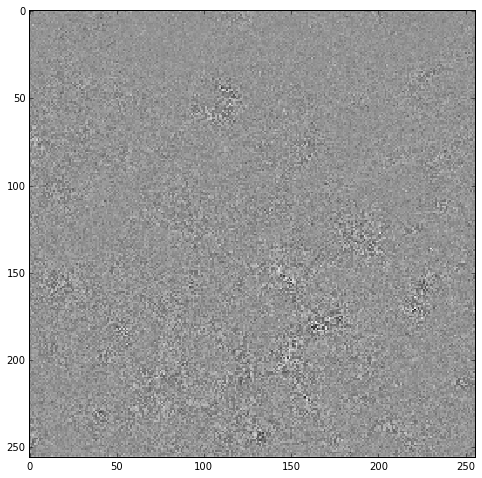

In [63]:
plt.imshow(d.mean(axis=1).reshape(256,256))

In [11]:
d.shape

(65536, 1000)

### Mean Subtraction

In [12]:
d = d - np.tile(d.mean(axis=1), (d.shape[1],1)).T

## Principal Component Analysis

In [7]:
from sklearn.decomposition import PCA

In [48]:
pca = PCA(n_components=0.99)

In [49]:
pca.fit(d.T[:500,:])
dpca = pca.transform(d.T[:500,:])

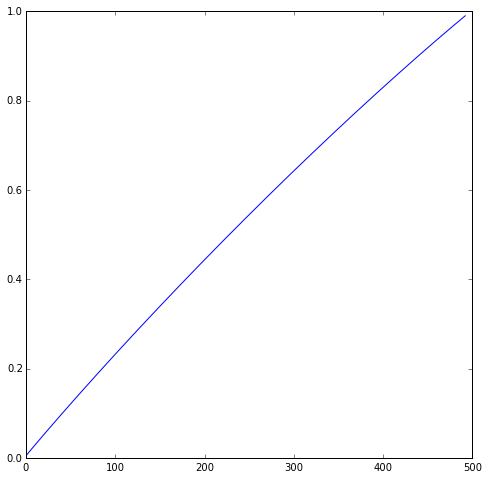

In [50]:
plt.plot(pca.explained_variance_ratio_[:].cumsum())

In [51]:
pca.components_.shape

(493, 65536)

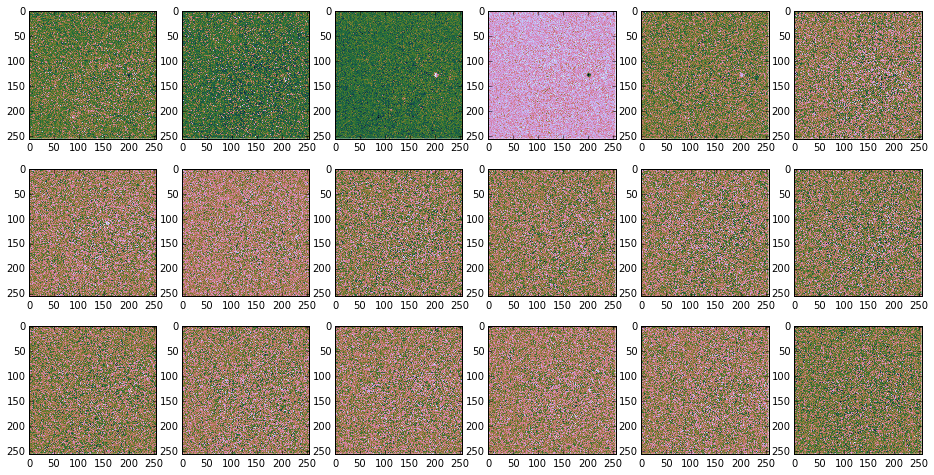

In [64]:
fig, ax = plt.subplots(ncols=6, nrows=3, figsize=(16, 8))
for i in range(18):
    ax[int(i/6)][np.mod(i,6)].imshow(pca.components_[i,:].reshape(256,256), cmap='cubehelix')

In [53]:
dpca.shape

(500, 493)

In [67]:
ax.imshow?

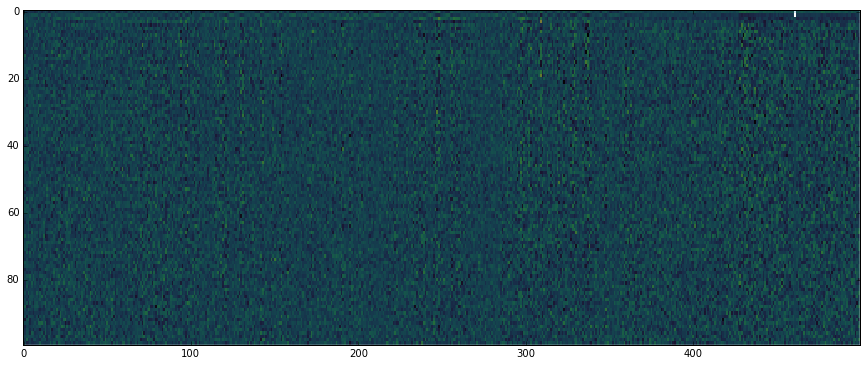

In [76]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.imshow(dpca.T[:100,:], cmap='cubehelix', aspect=2)

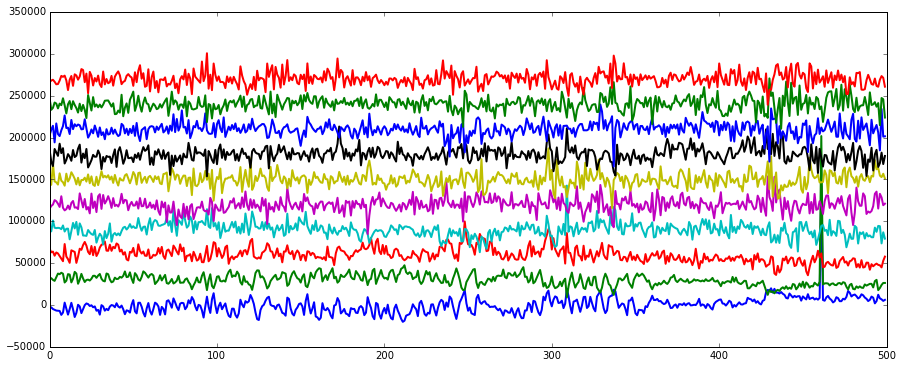

In [57]:
fig, ax = plt.subplots(figsize=(15,6))
for i in range(0, 10):
    ax.plot(dpca[:,i]+30000*i, lw=2)

In [80]:
from mpl_toolkits.mplot3d import Axes3D

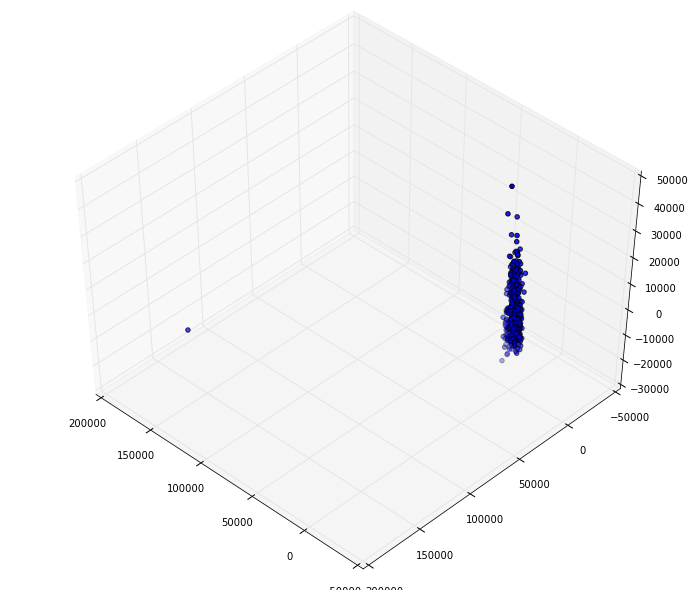

In [92]:
fig = plt.figure(figsize=(10, 8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(dpca[:,0], dpca[:,1], dpca[:,2])

In [93]:
dpca[:,0].shape

(500,)

### Running the large Dataset !!

In [4]:
from sklearn.decomposition import PCA, IncrementalPCA

In [5]:
datafile = '/home/michael/datac/140316/data5/data2/Image_0001_0001_channel1.tif'
data = neuralyzer.get_data(datafile)

[ 2015-04-16 13:15:29 ] [ log ] [ INFO ] : NEURALYZER LOGGER CREATED
[ 2015-04-16 13:15:29 ] [ log ] [ DEBUG ] : stdoutloglevel: DEBUG
[ 2015-04-16 13:15:29 ] [ data_handler ] [ DEBUG ] : root_path set to /home/michael/lib/neuralyzer/notebooks/dev
[ 2015-04-16 13:15:55 ] [ data_handler ] [ DEBUG ] : loaded data from cache file: /home/michael/datac/140316/data5/data2/Image_0001_0001_channel1.tif.hdf5


In [6]:
d = data.reshape(data.shape[0], data.shape[1]*data.shape[2]).T
dmean = d.mean(axis=1)
d = d - np.tile(dmean, (d.shape[1],1)).T
d.shape

(262144, 18000)

### Creating a memmap

In [9]:
d = d.T
dshape = d.shape
ddtype = d.dtype

In [11]:
d = d.T
memmapfile, _ = os.path.splitext(datafile)
memmapfile += '_memmap.dat'
dmm = np.memmap(memmapfile, dtype=ddtype, shape=dshape, mode='w+')
dmm[:] = d[:]
del dmm, d

#### do IncrementalPCA on memmap d

In [12]:
dmm = np.memmap(memmapfile, dtype=ddtype, shape=dshape, mode='w+')

In [ ]:
pca = IncrementalPCA()
pca.fit(dmm)
dpca = pca.transform(dmm)

In [ ]:
import datetime
print datetime.datetime.now()

## Singular Value Decomposition

In [ ]:
U, s, V = np.linalg.svd(d.T)

In [ ]:
def project_on_t_dim_space(x):    
    pone = np.empty(np.shape(x), 'float')

    # find projection pone onto N-dim orthonormal subspace of x via gram-schmidt 
    for i in range(np.shape(x)[1]):
        pone[:,i] = x[:,i]
        
        for j in range(i):
            pone[:,i] = pone[:,i] - np.dot(np.dot(pone[:,i], np.transpose(pone[:,j])), pone[:,j])

        pone[:,i] = pone[:,i] / np.sqrt(np.dot(pone[:,i], np.transpose(pone[:,i])))


In [22]:
def gs(X, row_vecs=True, norm=True):
    if not row_vecs:
        X = X.T
    Y = X[0:1,:].copy()
    for i in range(1, X.shape[0]):
        proj = np.diag((X[i,:].dot(Y.T)/np.linalg.norm(Y,axis=1)**2).flat).dot(Y)
        Y = np.vstack((Y, X[i,:] - proj.sum(0)))
    if norm:
        Y = np.diag(1/np.linalg.norm(Y,axis=1)).dot(Y)
    if row_vecs:
        return Y
    else:
        return Y.T

In [ ]:
P = gs(d.T)

In [22]:
def project_t(Y):
    '''
    Y : data in column vectors
    
    (N, T) = Y.shape with N >> T
    
    => find P to project Y[:,i] on T dim subspace.
    '''
    (N, T) = Y.shape
    P = Y[:,0:1].copy()
    for i in range(T):
        # project
        proj = np.diag((P[:,i].dot(P)/np.linalg.norm(P,axis=0)**2).flat).dot(P.T)
        P = np.vstack((P, Y[:,i] - proj.sum()))
    # normalize
    P = np.diag(1./np.linalg.norm(P, axis=0)).dot(P)
    return P